In [1]:
import sys
import numpy as np
import artm
print artm.version()

from os import path, mkdir
from datetime import datetime
%matplotlib inline
sys.path.insert(0, '..\\modules\\helpers')
sys.path.insert(0, '..\\modules\\completeness_solution')
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from artm_experiments import Experiment, Pool, OptimizationTopicsFilter

0.8.1


In [2]:
config = ConfigPaths('config.cfg')
plot_maker = PlotMaker()
printer = PrintHelper()

In [ ]:
print config.models_file_name

In [3]:
models_file = open(config.models_file_name, 'a')

In [4]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold):
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'ngramm': 1.0, 'author_id': 0.0, 'author': 0.0, 
                             'post_tag': 0.0, 'projects': 0.0, 'category': 0.0,
                             'following_users': 0.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model


def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold):
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      use_unigram_document_model=False,
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='ngramm'))
    artm_model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='ngramm', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='ngramm', num_tokens=n_top_tokens))

In [5]:
def process_one_model(dictionary, _n_topics, _n_doc_passes, _seed_value, _n_top_tokens, _p_mass_threshold, _n_iterations,
                     _model_name=''):
    print '[{}] creating model'.format(datetime.now())
    model = create_model(current_dictionary=dictionary, n_topics=_n_topics, n_doc_passes=_n_doc_passes, seed_value=_seed_value,
                         n_top_tokens=_n_top_tokens, p_mass_threshold=_p_mass_threshold)
    print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, output_file=models_file, n_iterations=_n_iterations, n_top_tokens=_n_top_tokens, p_threshold=_p_mass_threshold)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.dataset_path,
                                        data_format='bow_uci',
                                        collection_name=config.collection_name,
                                        target_folder=config.output_batches_path)
dictionary = artm.Dictionary()
dictionary.gather(data_path=config.output_batches_path,
                  vocab_file_path=config.vocabulary_path)
dictionary.save(dictionary_path=config.dictionary_path)
dictionary.save_text(dictionary_path=config.dictionary_path + '.txt')
dictionary.load_text(dictionary_path=config.dictionary_path + '.txt')

In [6]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

In [ ]:
# dictionary.filter(min_tf=5, max_tf=2000, min_df_rate=0.01, max_df_rate=0.9)

In [ ]:
model = process_one_model(dictionary, _n_topics=50, _n_doc_passes=5, _seed_value=100, _n_top_tokens=10, _p_mass_threshold=0.25,
                  _n_iterations=20, _model_name='model1')

In [ ]:
model = create_model(current_dictionary=dictionary, n_topics=50, n_doc_passes=5, seed_value=np.random.randint(1000),
                         n_top_tokens=10, p_mass_threshold=0.25)

In [8]:
def display_points(phi):
    points = ConvexHullTopicsFilter.project_points(phi.as_matrix().T, dim=2)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(points[:, 0], points[:, 1], marker='o', ls='')
    for i in xrange(phi.shape[1]):
        ax.annotate(phi.columns[i], xy=points[i], textcoords='offset points')
        
    plt.show()
    
def save_hist(vals, bins, filename):
    bins = (bins[:-1] + bins[1:]) / 2.0
    np.savetxt(filename, np.vstack((bins, vals)).T, delimiter=',')

[2016-11-11 22:38:02.519000] creating model
[2016-11-11 22:38:04.364000] fitting
[2016-11-11 22:38:37.607000] outputting
name = model_0, n_topics = True, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 10, p_threshold = 0.25



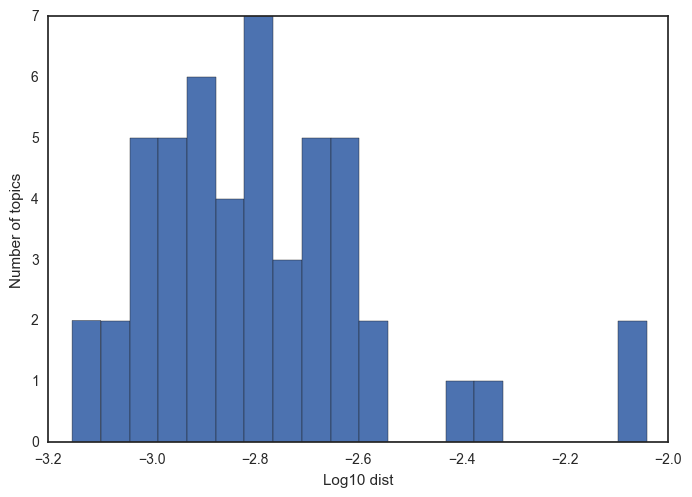

4
[2016-11-11 22:38:50.916000] creating model
[2016-11-11 22:38:52.546000] fitting
[2016-11-11 22:39:26.887000] outputting
name = model_1, n_topics = True, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 10, p_threshold = 0.25



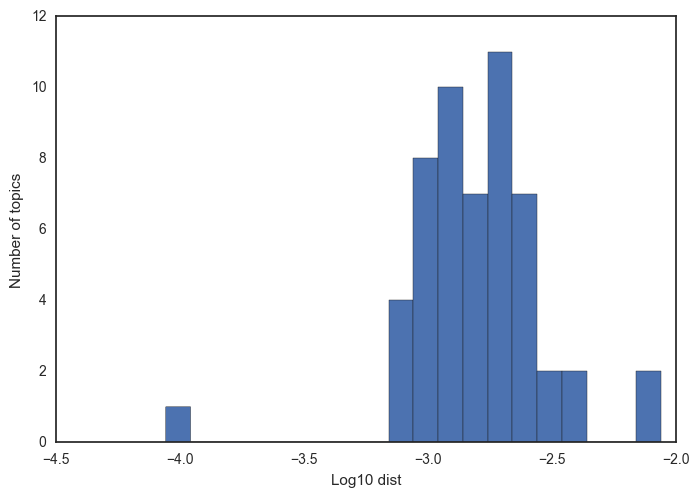

4
[2016-11-11 22:39:40.265000] creating model
[2016-11-11 22:39:42.025000] fitting
[2016-11-11 22:40:15.865000] outputting
name = model_2, n_topics = True, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 10, p_threshold = 0.25



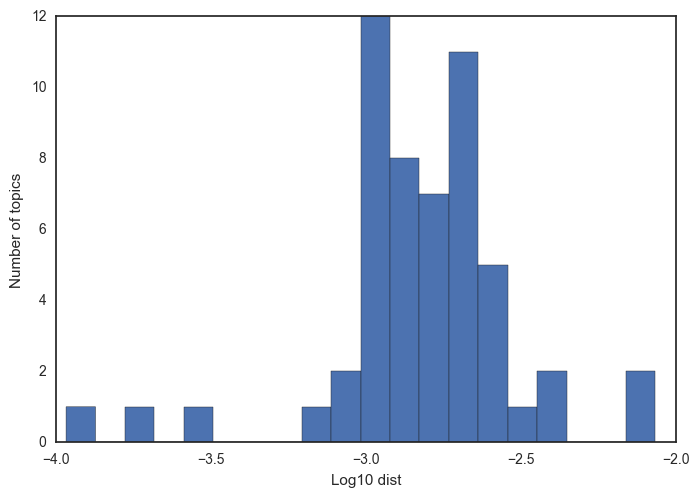

5


In [9]:
exp = Experiment(Pool(topics_filter=OptimizationTopicsFilter(eps=10 ** (-2.5), verbose=False), 
                      save_topics=True))
exp_models = []
for i in xrange(3):
    model_artm = process_one_model(dictionary, _n_topics=50, _n_doc_passes=5, _seed_value=100, _n_top_tokens=10, _p_mass_threshold=0.25,
                  _n_iterations=20, _model_name='model_{}'.format(i))
    exp_models.append(model_artm)
    #display_points(model_artm.get_phi())
    exp.collect_topics(model_artm.get_phi(), model_artm.get_theta())
    vals, bins = exp.topics_pool.topics_filter.plot_hist()
    save_hist(vals, bins, "data_iter_{}.csv".format(i))
    print exp.topics_pool.get_basic_topics_count()

In [ ]:
print exp.topics_pool.

In [ ]:
phi = model.get_phi()
th = model.get_theta()

In [ ]:
phi.columns

In [ ]:
exp.show_all_topics(sort_by_closest_topic=True)

In [ ]:
models_file.close()